# Portfolio simulation
#### Using Vasicek 2 factor model

Both the yield curve and the inflation rates are assumed to follow a Vasicek model.  
The movement of the two curves is given by a two dimensional correlated Brownian motion.

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from datetime import datetime

# Find the root directory by traversing up the directory tree
def find_project_root(current_path):
    if os.path.exists(os.path.join(current_path, "README.md")):
        return current_path
    parent_path = os.path.dirname(current_path)
    if parent_path == current_path:
        raise ValueError("Project root not found.")
    return find_project_root(parent_path)


current_dir = os.getcwd()
project_root = find_project_root(current_dir)
sys.path.append(str(project_root))
print(f"Project root: {project_root}")
from src.data.zerocurve import Zerocurve


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: f:\OneDrive\Documents\GitHub\rl-alm


In [6]:
def vasicek(r0, K, theta, sigma, T, N, seed=None):
    np.random.seed(seed)
    dt = T / float(N)
    rates = [r0]
    for i in range(N):
        dr = K * (theta - rates[-1]) * dt + sigma * np.random.normal()
        rates.append(rates[-1] + dr)
    return range(N+1), rates

This function takes the initial short-term interest rate (r0), mean reversion rate (K), long-term interest rate (theta), volatility (sigma), time horizon (T), number of time steps (N), and a seed for the random number generator (seed).

In [7]:
zerocurve = Zerocurve()
zerocurve.load_data()

2023-10-07 11:40:12.503 | INFO     | src.data.dataset:load_data:65 - loading zerocurve data from file.


In [8]:
data = zerocurve.df.pivot(columns = 'tenor', values = 'rate')

In [9]:
data.head()

tenor,0,3,6,9,12,15,18,24,36,48,60,84,120,180,360
rate_dt,,,,,,,,,,,,,,,
2010-06-01,0.198986,0.198986,0.233508,0.327186,0.466401,0.639714,0.837570,1.276560,2.182619,2.972319,3.576273,4.253072,4.429599,4.094338,3.695506
2010-06-02,0.195494,0.195494,0.240696,0.340034,0.481365,0.654421,0.850553,1.284313,2.183005,2.976086,3.592475,4.301162,4.495208,4.101261,3.559698
2010-06-03,0.197093,0.197093,0.255942,0.366852,0.518021,0.699466,0.902781,1.348057,2.262184,3.064966,3.687989,4.404611,4.601564,4.199481,3.637807
2010-06-04,0.194955,0.194955,0.245217,0.348856,0.493929,0.670320,0.869504,1.308855,2.217980,3.021255,3.647283,4.370987,4.572712,4.164582,3.584203
2010-06-07,0.190019,0.190019,0.245832,0.354690,0.504743,0.685941,0.889797,1.338168,2.263965,3.081217,3.717309,4.446700,4.623877,4.135585,3.424269


In [23]:
data.iloc[0, :]

tenor
0      0.198986
3      0.198986
6      0.233508
9      0.327186
12     0.466401
15     0.639714
18     0.837570
24     1.276560
36     2.182619
48     2.972319
60     3.576273
84     4.253072
120    4.429599
180    4.094338
360    3.695506
Name: 2010-06-01 00:00:00, dtype: float64

In [25]:
start_date = data.index.min()
end_date = data.index.max()
pred_end_date = datetime(2023,12,31)

<Axes: xlabel='tenor', ylabel='tenor'>

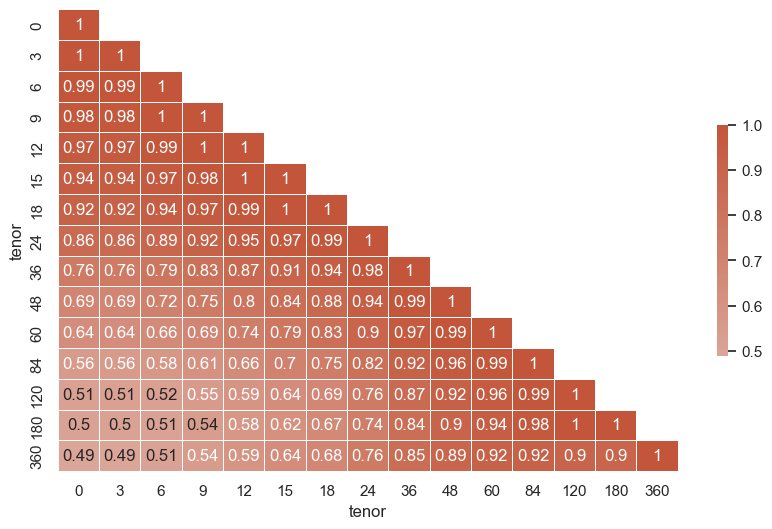

In [42]:
correlation_matrix = data.corr()
sns.set_theme(style="white")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
np.fill_diagonal(mask, False)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, center = 0, cmap = cmap, mask= mask, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
yield_data = data
rate_changes = np.log(yield_data / yield_data.shift(1)).dropna()

f:\OneDrive\Documents\GitHub\rl-alm\rl-alm\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [44]:
mu = rate_changes.mean().values
sigma = rate_changes.std().values

In [46]:
r0 = yield_data.iloc[-1].values # last observerd yield
T = 1 # time horizon
dt = 1/252 # time step

# Vasicek Interest Rate Model

https://www.investopedia.com/terms/v/vasicek-model.asp#:~:text=The%20term%20Vasicek%20Interest%20Rate,will%20move%20in%20the%20future.

In [47]:
def vasicek(r, mu, sigma, dt):
    return r + mu*dt + sigma*np.sqrt(dt)*np.random.normal()

In [48]:
yield_curve = [r0]
for i in range(int(T/dt)):
    r = yield_curve[-1]
    yield_curve.append(vasicek(r, mu, sigma, dt))

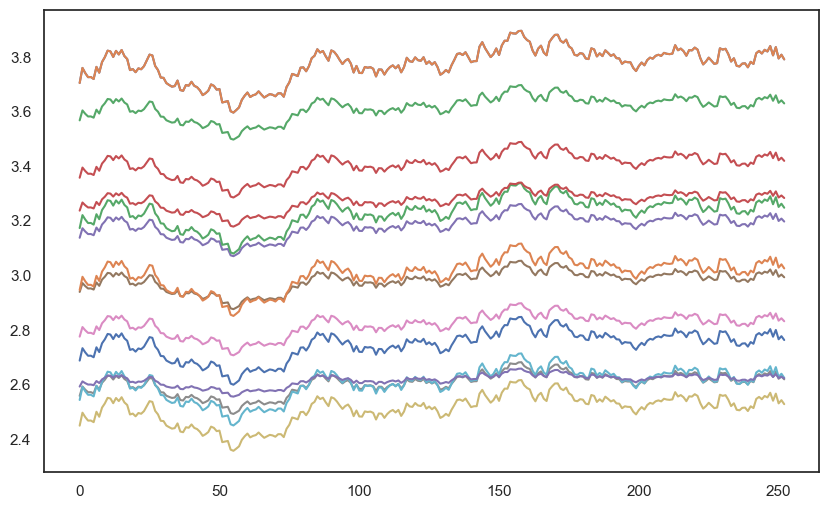

In [49]:
plt.plot(yield_curve)
plt.show()